# 문제정의
* The International Airline Passengers
* 년 단위 항공기 이용 승객 데이터를 이용하여 다음 번 승객의 수를 예측해봅니다.
* Time-series Regression 문제입니다.

# 데이터 준비
* 웹에 공개된 the International Airline Passengers의 csv 형태의 데이터를 이용합니다.
* https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line


      Month  Passengers
0   1949-01         112
1   1949-02         118
2   1949-03         132
3   1949-04         129
4   1949-05         121
5   1949-06         135
6   1949-07         148
7   1949-08         148
8   1949-09         136
9   1949-10         119
10  1949-11         104
11  1949-12         118
       Month  Passengers
132  1960-01         417
133  1960-02         391
134  1960-03         419
135  1960-04         461
136  1960-05         472
137  1960-06         535
138  1960-07         622
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432


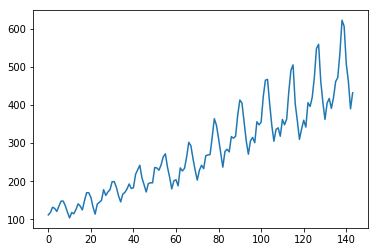

(132, 13)
   t-12  t-11  t-10  t-9  t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1  t-0
0   112   118   132  129  121  135  148  148  136  119  104  118  115
1   118   132   129  121  135  148  148  136  119  104  118  115  126
2   132   129   121  135  148  148  136  119  104  118  115  126  141
3   129   121   135  148  148  136  119  104  118  115  126  141  135
4   121   135   148  148  136  119  104  118  115  126  141  135  125
5   135   148   148  136  119  104  118  115  126  141  135  125  149
     t-12  t-11  t-10  t-9  t-8  t-7  t-6  t-5  t-4  t-3  t-2  t-1  t-0
126   548   559   463  407  362  405  417  391  419  461  472  535  622
127   559   463   407  362  405  417  391  419  461  472  535  622  606
128   463   407   362  405  417  391  419  461  472  535  622  606  508
129   407   362   405  417  391  419  461  472  535  622  606  508  461
130   362   405   417  391  419  461  472  535  622  606  508  461  390
131   405   417   391  419  461  472  535  622  606  508  461  390  

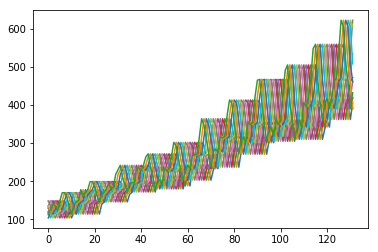

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 데이터는 월별 항공 승객 수를 가지고 있습니다. (천단위 절삭)
path_data = "../datasets/international-airline-passengers.csv"
columns = ['Month', 'Passengers']
df_data = pd.read_csv(path_data, names=columns, skiprows=1, nrows=144)
print(df_data.head(12))
print(df_data.tail(12))
#plt.plot(df_data["Passengers"], 'ro')
plt.plot(df_data["Passengers"])
plt.show()

# 이전 12 개월치 승객 수(x) 를 이용해서 
# 다음달 승객 수(y) 를 추측할 수 있도록 데이터를 변형해 줍니다.
len_data = len(df_data["Passengers"])
columns = []
column_names = []
months = 12
for i in range(0, months + 1):
    shift = (months - i)
    column = df_data["Passengers"][i:len_data - shift].reset_index(drop=True)
    columns.append(column)
    column_names.append("t-%s" % shift)
xy = pd.concat(columns, keys=column_names, axis=1)
    
print(xy.shape)
plt.plot(xy)
print(xy.head(6))
print(xy.tail(6))

# 훈련과 평가를 위해 데이터 셋을 대략 7:3 정도로 훈련/테스트용으로 나누어 줍니다.
train_data = xy[:][0:100].reset_index(drop=True)
test_data = xy[:][100:-1].reset_index(drop=True)
print(train_data.shape)
print(test_data.shape)

# 알고리즘 선택
* 시계열 데이터 셋 예측을 위해 RNN의 한 종류인 LSTM을 사용해 보도록 합니다.
* tensorflow v1.0

In [2]:
from sklearn import preprocessing
# train_sdata = train_data.values
# test_sdata = test_data.values

# 빠른 훈련을 위해 min max 값을 이용하여 0~1 값을 가지도록 normalization 합니다.
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
train_sdata = scaler.fit_transform(train_data).astype('float32')
test_sdata = scaler.fit_transform(test_data).astype('float32')
print(type(train_sdata), train_sdata.shape)
print(type(test_sdata), test_sdata.shape)

# 훈련시 사용할 다음 랜덤 batch를 생성함수를 미리 만들어 줍니다.
def next_batch(sdata, size):
    data = np.array(sdata, copy=True)
    x_dim = data.shape[1] - 1
    if (size <= 0):
        return data[:, :x_dim].reshape(-1, x_dim, 1), data[:, -1].reshape(-1, 1)
    np.random.shuffle(data)
    sample = data[:size]
    #print(sample.shape)
    #print(sample)
    return sample[:, :x_dim].reshape(-1, x_dim, 1), sample[:, -1].reshape(-1, 1)

xs, ys = next_batch(train_sdata, 0)
print(xs[:2])
print(ys[:2])
print(xs.shape, ys.shape)
xs, ys = next_batch(test_sdata, 0)
print(xs.shape, ys.shape)

<class 'numpy.ndarray'> (100, 13)
<class 'numpy.ndarray'> (31, 13)
[[[ 0.02588997]
  [ 0.04530744]
  [ 0.08805031]
  [ 0.06925208]
  [ 0.04683195]
  [ 0.08539945]
  [ 0.12121212]
  [ 0.12121212]
  [ 0.08815427]
  [ 0.04132231]
  [ 0.        ]
  [ 0.01133144]]

 [[ 0.04530744]
  [ 0.09061489]
  [ 0.07861635]
  [ 0.04709141]
  [ 0.08539945]
  [ 0.12121212]
  [ 0.12121212]
  [ 0.08815427]
  [ 0.04132231]
  [ 0.        ]
  [ 0.03856749]
  [ 0.00283286]]]
[[ 0.00283286]
 [ 0.03399434]]
(100, 12, 1) (100, 1)
(31, 12, 1) (31, 1)


In [3]:
import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow.contrib import rnn

# Tensorflow를 이용해 LSTM 모델을 생성합니다.
# 입력으로 1차원 input 12개를 받고 12개의 output를 내는 12층을 가진 LSTM 입니다.
lstm_size = 1 
time_step_size = 12
stack_size = 12
input_dim = 1

# input
feed_xs = tf.placeholder(tf.float32, shape=[None, time_step_size, input_dim])
print(feed_xs)
feed_ys = tf.placeholder(tf.float32, shape=[None, lstm_size])
print(feed_ys)

# LSTM layer
lstm_cell = rnn.BasicLSTMCell(lstm_size, state_is_tuple=True)
stacked_lstm = rnn.MultiRNNCell([lstm_cell] * stack_size, state_is_tuple=True)
outputs, states = tf.nn.dynamic_rnn(stacked_lstm, feed_xs, dtype=dtypes.float32)
print(outputs)

# cost
# 최종 예측 y값은 1차원이므로 LSTM output에서 마지막 차원 값을 cost를 계산시 사용합니다.
pred_ys = outputs[:, -1]
print(pred_ys)

learning_rate = 0.0001
cost = tf.reduce_sum(tf.square(feed_ys - pred_ys))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Tensor("Placeholder:0", shape=(?, 12, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
Tensor("rnn/transpose:0", shape=(?, 12, 1), dtype=float32)
Tensor("strided_slice:0", shape=(?, 1), dtype=float32)


In [4]:
def mkdir(dir_path):
    if tf.gfile.Exists(dir_path):
        tf.gfile.DeleteRecursively(dir_path)
    tf.gfile.MakeDirs(dir_path)

def train_epoch(epoch, steps, batch_size):
    init = tf.global_variables_initializer()
    sess.run(init)

    saver = tf.train.Saver()
    path_format = "../models/tf-rnn-iap-%03d/"
    prev_model_path = path_format % (epoch - 1)
    prev_model_file = "%s%s" % (prev_model_path, "model")
    if tf.gfile.Exists(prev_model_path):
        saver.restore(sess, prev_model_file)

    for step in range(steps):
        train_xs, train_ys = next_batch(train_sdata, batch_size)
        sess.run(optimizer, feed_dict={feed_xs: train_xs, feed_ys: train_ys})

    train_xs, train_ys = next_batch(train_sdata, 0)
    train_cost, train_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: train_xs, feed_ys: train_ys})
    print("epoch: %s, train_cost: %s" % (epoch, train_cost))

    test_xs, test_ys = next_batch(test_sdata, 0)
    test_cost, test_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: test_xs, feed_ys: test_ys})
    print("epoch: %s, test_cost: %s" % (epoch, test_cost))

    curr_model_path = path_format % epoch
    curr_model_file = "%s%s" % (curr_model_path, "model")
    print("save model: %s" % curr_model_file)
    mkdir(curr_model_path)
    saver.save(sess, curr_model_file)

# 배치 사이즈는 1개이고 각 epoch 마다 10만 스텝의 최적화 후 모델을 저장합니다.
batch_size = 1
with tf.Session() as sess:
    for epoch in range(0, 5):    
        train_epoch(epoch, 100000, batch_size)


epoch: 0, train_cost: 0.244708
epoch: 0, test_cost: 0.206172
save model: ../models/tf-rnn-iap-000/model
epoch: 1, train_cost: 0.195966
epoch: 1, test_cost: 0.202881
save model: ../models/tf-rnn-iap-001/model
epoch: 2, train_cost: 0.194045
epoch: 2, test_cost: 0.206892
save model: ../models/tf-rnn-iap-002/model
epoch: 3, train_cost: 0.247291
epoch: 3, test_cost: 0.136689
save model: ../models/tf-rnn-iap-003/model
epoch: 4, train_cost: 0.188916
epoch: 4, test_cost: 0.204153
save model: ../models/tf-rnn-iap-004/model


In [11]:
# 훈련된 모델 중 하나를 불러옵니다.
with tf.Session() as sess:
    epoch = 4
    init = tf.global_variables_initializer()
    sess.run(init)

    saver = tf.train.Saver()

    path_format = "../models/tf-rnn-iap-%03d/"
    curr_model_path = path_format % epoch
    curr_model_file = "%s%s" % (curr_model_path, "model")
    saver.restore(sess, curr_model_file)

    train_xs, train_ys = next_batch(train_sdata, 0)
    train_cost, train_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: train_xs, feed_ys: train_ys})
    print("epoch: %s, train_cost: %s" % (epoch, train_cost))

    test_xs, test_ys = next_batch(test_sdata, 0)
    test_cost, test_pred_ys = sess.run([cost, pred_ys], feed_dict={feed_xs: test_xs, feed_ys: test_ys})
    print("epoch: %s, test_cost: %s" % (epoch, test_cost))


epoch: 4, train_cost: 0.188916
epoch: 4, test_cost: 0.204153


(100, 1)


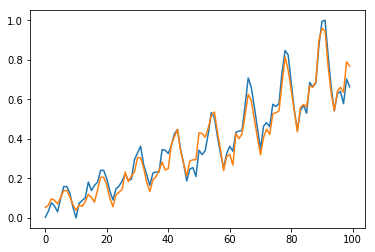

In [12]:
# 훈련 데이터 값과 예측치를 비교해 봅니다.
np_py = np.array(train_pred_ys)
print(np_py.shape)
plt.plot(train_ys)
plt.plot(np_py.reshape(-1, 1))

(31, 1)


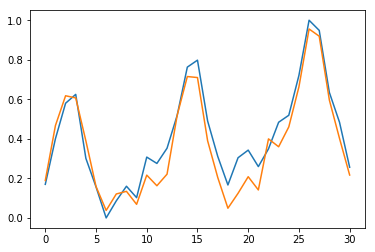

In [13]:
# 테스트 데이터 값과 예측치를 비교해 봅니다. 
# LSTM을 통해 반복되는 시계열 경향성 예측을 상당히 정확하게 할 수 있다는 것을 알수 있습니다.
np_py = np.array(test_pred_ys)
print(np_py.shape)
plt.plot(test_ys)
plt.plot(np_py.reshape(-1, 1))